# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold, GridSearchCV
from visualkeras import layered_view
import os
import cv2
np.random.seed(42)
tf.random.set_seed(42)

## Importing the Data

In [36]:
train_dir = 'archive/Training'
test_dir = 'archive/Testing'

In [38]:
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [39]:
def count_images(directory):
    count = {}
    for folder in os.listdir(directory):
        count[folder] = len(os.listdir(os.path.join(directory, folder)))
    return count

print("Training set distribution:", count_images(train_dir))
print("Test set distribution:", count_images(test_dir))

Training set distribution: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test set distribution: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


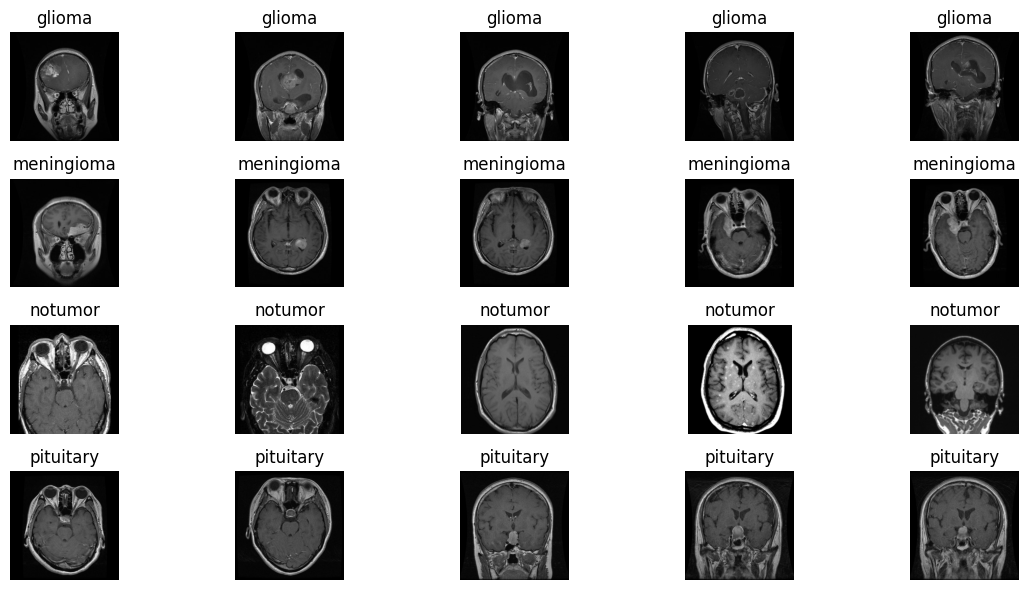

In [42]:
def visualize_samples(directory, num_samples=5):
    categories = os.listdir(directory)
    plt.figure(figsize=(12, 6))
    
    for category in categories:
        image_files = os.listdir(os.path.join(directory, category))
        for i in range(num_samples):
            img = plt.imread(os.path.join(directory, category, image_files[i]))
            plt.subplot(len(categories), num_samples, categories.index(category) * num_samples + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir)

In [44]:
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 4571 images belonging to 4 classes.


In [46]:
def complex_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    return model

In [48]:
m = complex_model()

plot_model(m, to_file='complex_model.png', show_shapes=True, show_layer_names=True)
m.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 2

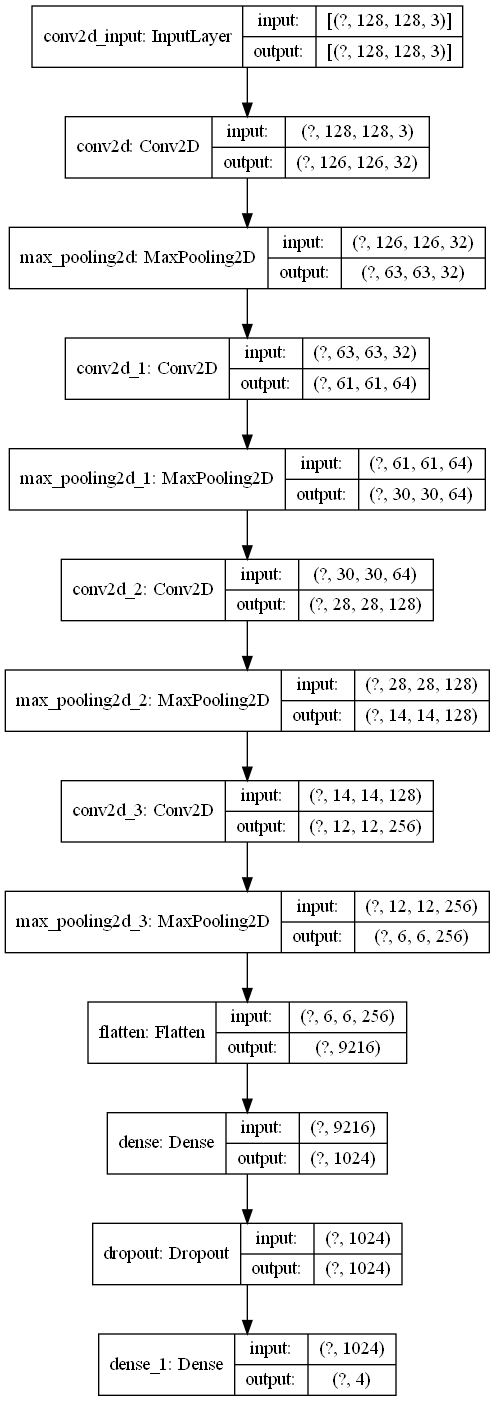

In [50]:
from IPython.display import Image
Image(retina=True, filename='complex_model.png')

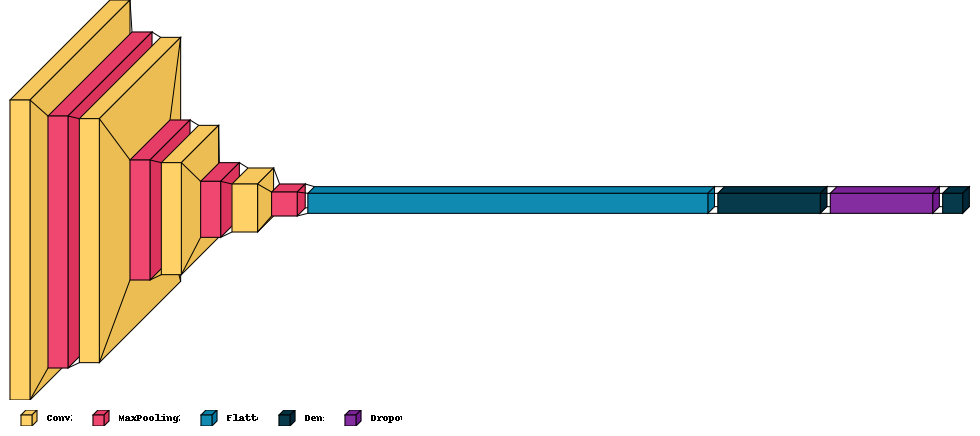

In [52]:
layered_view(m, legend=True, max_xy=300)

In [62]:
cpu_model = complex_model()
cpu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

gpu_model = complex_model()
gpu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [56]:
with tf.device('/CPU:0'):
    cpu_history = cpu_model.fit(
        augmented_train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/15
143/143 [==============================] - 59s 402ms/step - loss: 1.0519 - accuracy: 0.5058 - val_loss: 2.0022 - val_accuracy: 0.4023
Epoch 2/15
143/143 [==============================] - 58s 403ms/step - loss: 0.8171 - accuracy: 0.6587 - val_loss: 1.1031 - val_accuracy: 0.6065
Epoch 3/15
143/143 [==============================] - 55s 387ms/step - loss: 0.7043 - accuracy: 0.7173 - val_loss: 1.0064 - val_accuracy: 0.6687
Epoch 4/15
143/143 [==============================] - 55s 385ms/step - loss: 0.5644 - accuracy: 0.7716 - val_loss: 1.1148 - val_accuracy: 0.6564
Epoch 5/15
143/143 [==============================] - 56s 389ms/step - loss: 0.5220 - accuracy: 0.7976 - val_loss: 0.9055 - val_accuracy: 0.6985
Epoch 6/15
143/143 [==============================] - 56s 393ms/step - loss: 0.4523 - accuracy: 0.8270 - val_loss: 0.7967 - val_accuracy: 0.7222
Epoch 7/15
143/143 [==============================] - 57s 401ms/step - loss: 0.4427 - accuracy: 0.8276 - val_loss: 0.6166 - val_ac

In [64]:
with tf.device('/GPU:0'):
    gpu_history = gpu_model.fit(
        augmented_train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/15
143/143 [==============================] - 58s 394ms/step - loss: 1.0701 - accuracy: 0.5067 - val_loss: 1.1733 - val_accuracy: 0.5478
Epoch 2/15
143/143 [==============================] - 53s 369ms/step - loss: 0.8302 - accuracy: 0.6327 - val_loss: 1.9384 - val_accuracy: 0.5022
Epoch 3/15
143/143 [==============================] - 54s 376ms/step - loss: 0.7346 - accuracy: 0.6948 - val_loss: 1.2634 - val_accuracy: 0.5863
Epoch 4/15
143/143 [==============================] - 54s 376ms/step - loss: 0.6549 - accuracy: 0.7355 - val_loss: 1.4750 - val_accuracy: 0.5460
Epoch 5/15
143/143 [==============================] - 53s 369ms/step - loss: 0.6024 - accuracy: 0.7469 - val_loss: 0.8742 - val_accuracy: 0.6740
Epoch 6/15
143/143 [==============================] - 53s 370ms/step - loss: 0.5590 - accuracy: 0.7762 - val_loss: 0.9593 - val_accuracy: 0.6547
Epoch 7/15
143/143 [==============================] - 53s 373ms/step - loss: 0.5007 - accuracy: 0.8040 - val_loss: 0.9638 - val_ac

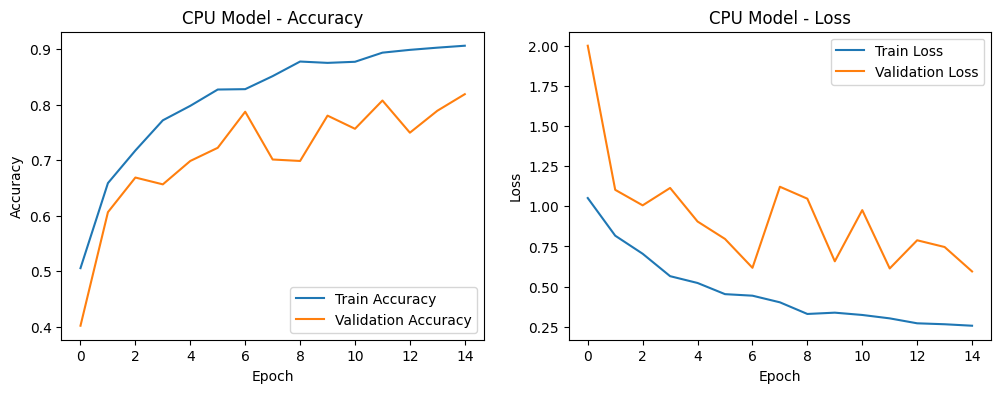

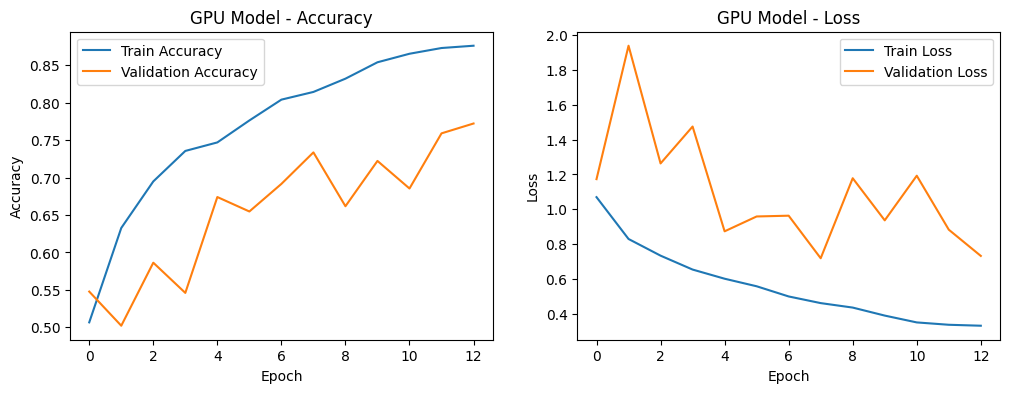

41/41 [==============================] - 3s 80ms/step - loss: 0.6669 - accuracy: 0.7338
CPU Model - Test Accuracy: 33.18%
GPU Model - Test Accuracy: 73.38%
CPU Model - CPU Loss: 1.3860129117965698
GPU Model - GPU Loss: 0.6668681502342224


In [66]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    plt.show()

plot_history(cpu_history, "CPU Model")
plot_history(gpu_history, "GPU Model")

cpu_test_loss, cpu_test_accuracy = cpu_model.evaluate(test_generator)
gpu_test_loss, gpu_test_accuracy = gpu_model.evaluate(test_generator)

print(f"CPU Model - Test Accuracy: {cpu_test_accuracy * 100:.2f}%")
print(f"GPU Model - Test Accuracy: {gpu_test_accuracy * 100:.2f}%")
print(f"CPU Model - CPU Loss: {cpu_test_loss}")
print(f"GPU Model - GPU Loss: {gpu_test_loss}")

# Hyperparamter

In [69]:
optimizers = [Adam(), SGD(), RMSprop()]
histories = []

In [71]:
def train_model_with_optimizer(optimizer):
    gpu_model_new = complex_model()
    gpu_model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = gpu_model_new.fit(
        augmented_train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[early_stopping, model_checkpoint]
    )
    return history

# Train the model with each optimizer
with tf.device('/GPU:0'):
    for optimizer in optimizers:
        history = train_model_with_optimizer(optimizer)
        histories.append((optimizer, history))

# Extract final metrics from each history
results = []
for optimizer, history in histories:
    final_loss = history.history['loss'][-1]
    final_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    results.append([optimizer.__class__.__name__, final_loss, final_accuracy, final_val_loss, final_val_accuracy])

# Create a DataFrame to display the results
columns = ['Optimizer', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy']
df_results = pd.DataFrame(results, columns=columns)

# Display the results
print(df_results)

Epoch 1/20
143/143 [==============================] - 74s 508ms/step - loss: 1.0359 - accuracy: 0.5165 - val_loss: 1.8242 - val_accuracy: 0.4470
Epoch 2/20
143/143 [==============================] - 55s 385ms/step - loss: 0.8171 - accuracy: 0.6589 - val_loss: 1.0585 - val_accuracy: 0.6415
Epoch 3/20
143/143 [==============================] - 55s 382ms/step - loss: 0.7057 - accuracy: 0.7103 - val_loss: 1.1177 - val_accuracy: 0.6389
Epoch 4/20
143/143 [==============================] - 55s 386ms/step - loss: 0.6396 - accuracy: 0.7377 - val_loss: 1.2836 - val_accuracy: 0.5670
Epoch 5/20
143/143 [==============================] - 55s 383ms/step - loss: 0.5958 - accuracy: 0.7703 - val_loss: 0.9243 - val_accuracy: 0.6740
Epoch 6/20
143/143 [==============================] - 56s 392ms/step - loss: 0.5523 - accuracy: 0.7865 - val_loss: 0.9283 - val_accuracy: 0.7143
Epoch 7/20
143/143 [==============================] - 57s 399ms/step - loss: 0.5200 - accuracy: 0.7946 - val_loss: 0.9933 - val_ac

In [73]:
df_results

,Optimizer,Loss,Accuracy,Val_Loss,Val_Accuracy
0,Adam,0.296365,0.889740,0.578611,0.818580
1,SGD,0.807476,0.664187,1.027755,0.626643
2,RMSprop,0.264529,0.909867,0.414062,0.868536


In [47]:
df_results

,Optimizer,Loss,Accuracy,Val_Loss,Val_Accuracy
0,Adam,0.262523,0.905491,1.029226,0.714286
1,SGD,0.779278,0.686721,0.924433,0.664330
2,RMSprop,0.284134,0.896303,0.758251,0.797546


In [75]:
# Extract final metrics from each history
optimizer_names = [optimizer.__class__.__name__ for optimizer, _ in histories]
training_loss = {optimizer.__class__.__name__: history.history['loss'] for optimizer, history in histories}
training_accuracy = {optimizer.__class__.__name__: history.history['accuracy'] for optimizer, history in histories}
validation_loss = {optimizer.__class__.__name__: history.history['val_loss'] for optimizer, history in histories}
validation_accuracy = {optimizer.__class__.__name__: history.history['val_accuracy'] for optimizer, history in histories}


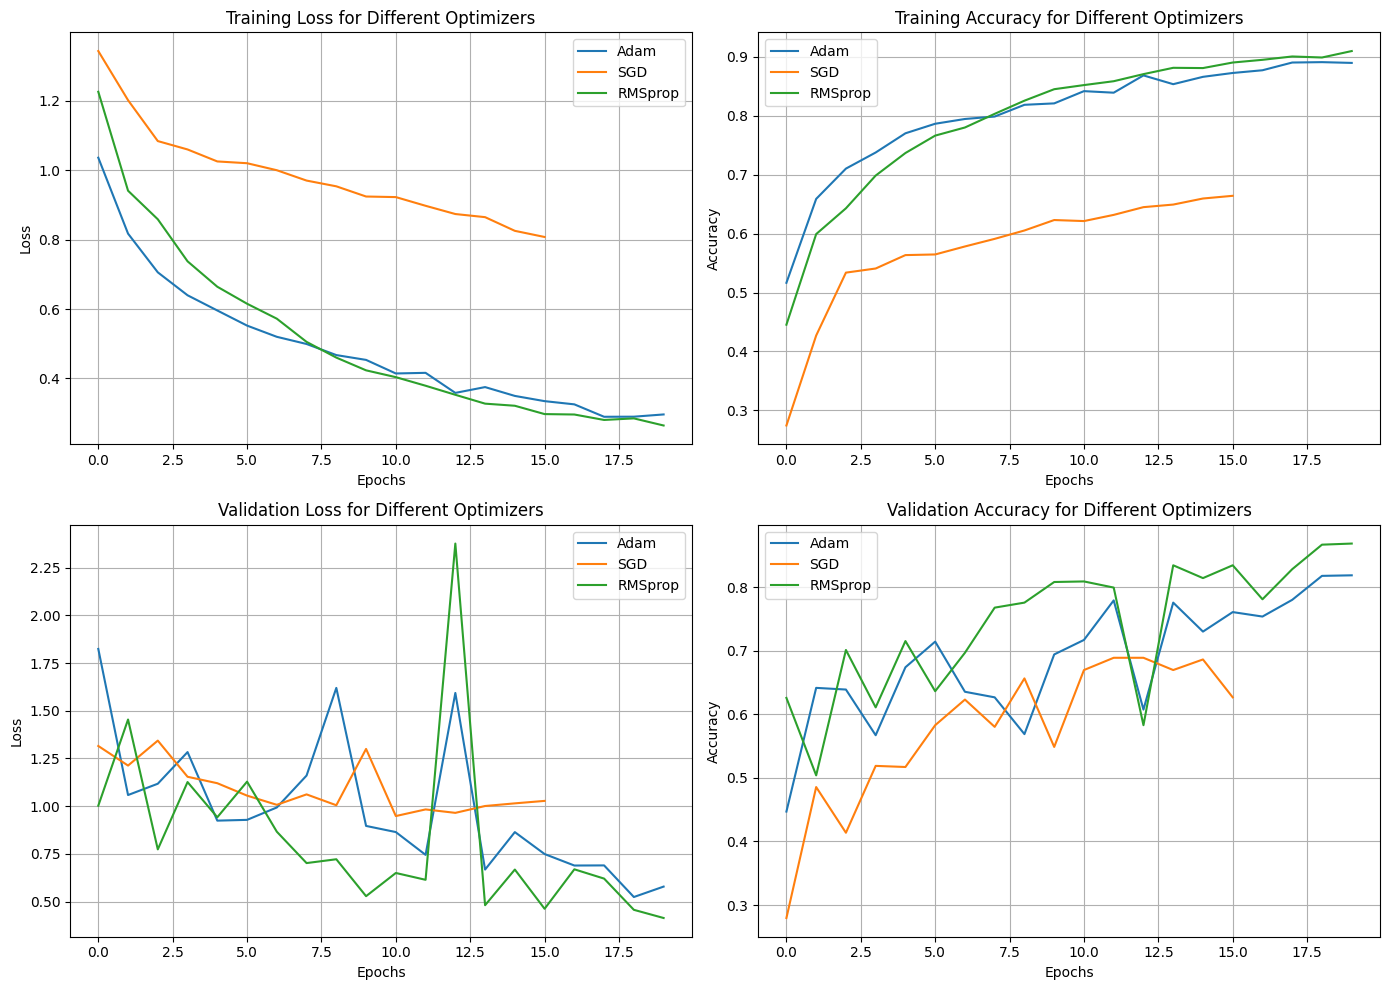

In [77]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics in subplots
def plot_metrics_subplot(training_loss, training_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot training loss
    axs[0, 0].set_title('Training Loss for Different Optimizers')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    for name, values in training_loss.items():
        axs[0, 0].plot(values, label=name)
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot training accuracy
    axs[0, 1].set_title('Training Accuracy for Different Optimizers')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    for name, values in training_accuracy.items():
        axs[0, 1].plot(values, label=name)
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot validation loss
    axs[1, 0].set_title('Validation Loss for Different Optimizers')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    for name, values in validation_loss.items():
        axs[1, 0].plot(values, label=name)
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot validation accuracy
    axs[1, 1].set_title('Validation Accuracy for Different Optimizers')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    for name, values in validation_accuracy.items():
        axs[1, 1].plot(values, label=name)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot all metrics in a 2x2 grid
plot_metrics_subplot(training_loss, training_accuracy, validation_loss, validation_accuracy)

In [79]:
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import ParameterGrid

# Define the grid of hyperparameters
param_grid = {
    'optimizer': [RMSprop],
    'learning_rate': [1e-3, 1e-2],
    'batch_size': [16, 32],
    'dropout_rate': [0.3, 0.5]
}

# Create a list of parameter combinations
param_combinations = list(ParameterGrid(param_grid))

In [85]:
def build_model(optimizer_class, learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    
    optimizer = optimizer_class(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [87]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

best_val_accuracy = 0
best_params = None
best_model = None

# Initialize early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_grid_search.h5', save_best_only=True)

# Perform grid search
for params in param_combinations:
    print(f"Training with parameters: {params}")
    
    # Extract parameters
    optimizer_class = params['optimizer']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    #dense_units = params['dense_units']
    dropout_rate = params['dropout_rate']
    
    # Build and train the model
    model = build_model(optimizer_class, learning_rate, dropout_rate)
    
    with tf.device('/GPU:0'):
        history = model.fit(
            augmented_train_generator,
            epochs=15,
            validation_data=val_generator,
            callbacks=[early_stopping, model_checkpoint],
            batch_size=batch_size
        )
    
    # Evaluate the model
    val_accuracy = np.max(history.history['val_accuracy'])
    
    # Check if this model is the best
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_model = model

Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_experimental.rmsprop.RMSprop'>}
Epoch 1/15
143/143 [==============================] - 54s 372ms/step - loss: 1.2253 - accuracy: 0.4065 - val_loss: 1.9048 - val_accuracy: 0.3453
Epoch 2/15
143/143 [==============================] - 53s 368ms/step - loss: 0.9556 - accuracy: 0.5870 - val_loss: 1.6461 - val_accuracy: 0.4356
Epoch 3/15
143/143 [==============================] - 52s 363ms/step - loss: 0.8449 - accuracy: 0.6480 - val_loss: 1.4075 - val_accuracy: 0.5118
Epoch 4/15
143/143 [==============================] - 54s 378ms/step - loss: 0.7565 - accuracy: 0.6953 - val_loss: 0.8457 - val_accuracy: 0.6924
Epoch 5/15
143/143 [==============================] - 54s 378ms/step - loss: 0.6813 - accuracy: 0.7195 - val_loss: 0.9006 - val_accuracy: 0.6985
Epoch 6/15
143/143 [==============================] - 55s 383ms/step - loss: 0.6386 - accuracy: 0.7480 - 

In [89]:
print("Best Validation Accuracy:", best_val_accuracy)
print("Best Hyperparameters:", best_params)

Best Validation Accuracy: 0.8466257452964783
Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_experimental.rmsprop.RMSprop'>}


In [91]:
best_params

{'batch_size': 32,
 'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'optimizer': keras.optimizers.optimizer_experimental.rmsprop.RMSprop}

In [93]:
# Define a function to build the model with the best hyperparameters
def build_best_model(optimizer_class, learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    
    optimizer = optimizer_class(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model with the best hyperparameters
best_model = build_best_model(
    best_params['optimizer'],
    best_params['learning_rate'],
    best_params['dropout_rate']
)

# Initialize early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_final.h5', save_best_only=True)

# Train the model on GPU
with tf.device('/GPU:0'):
    best_model_history = best_model.fit(
        augmented_train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[early_stopping, model_checkpoint],
        batch_size=best_params['batch_size']
    )

Epoch 1/15
143/143 [==============================] - 65s 452ms/step - loss: 1.2293 - accuracy: 0.4259 - val_loss: 1.4179 - val_accuracy: 0.4189
Epoch 2/15
143/143 [==============================] - 64s 445ms/step - loss: 0.9920 - accuracy: 0.5769 - val_loss: 1.8467 - val_accuracy: 0.3953
Epoch 3/15
143/143 [==============================] - 65s 454ms/step - loss: 0.8547 - accuracy: 0.6489 - val_loss: 1.3139 - val_accuracy: 0.5679
Epoch 4/15
143/143 [==============================] - 63s 443ms/step - loss: 0.7622 - accuracy: 0.6848 - val_loss: 1.2490 - val_accuracy: 0.5627
Epoch 5/15
143/143 [==============================] - 65s 453ms/step - loss: 0.7049 - accuracy: 0.7226 - val_loss: 0.8210 - val_accuracy: 0.6766
Epoch 6/15
143/143 [==============================] - 65s 454ms/step - loss: 0.6499 - accuracy: 0.7392 - val_loss: 1.0486 - val_accuracy: 0.6389
Epoch 7/15
143/143 [==============================] - 66s 461ms/step - loss: 0.6115 - accuracy: 0.7541 - val_loss: 0.7718 - val_ac

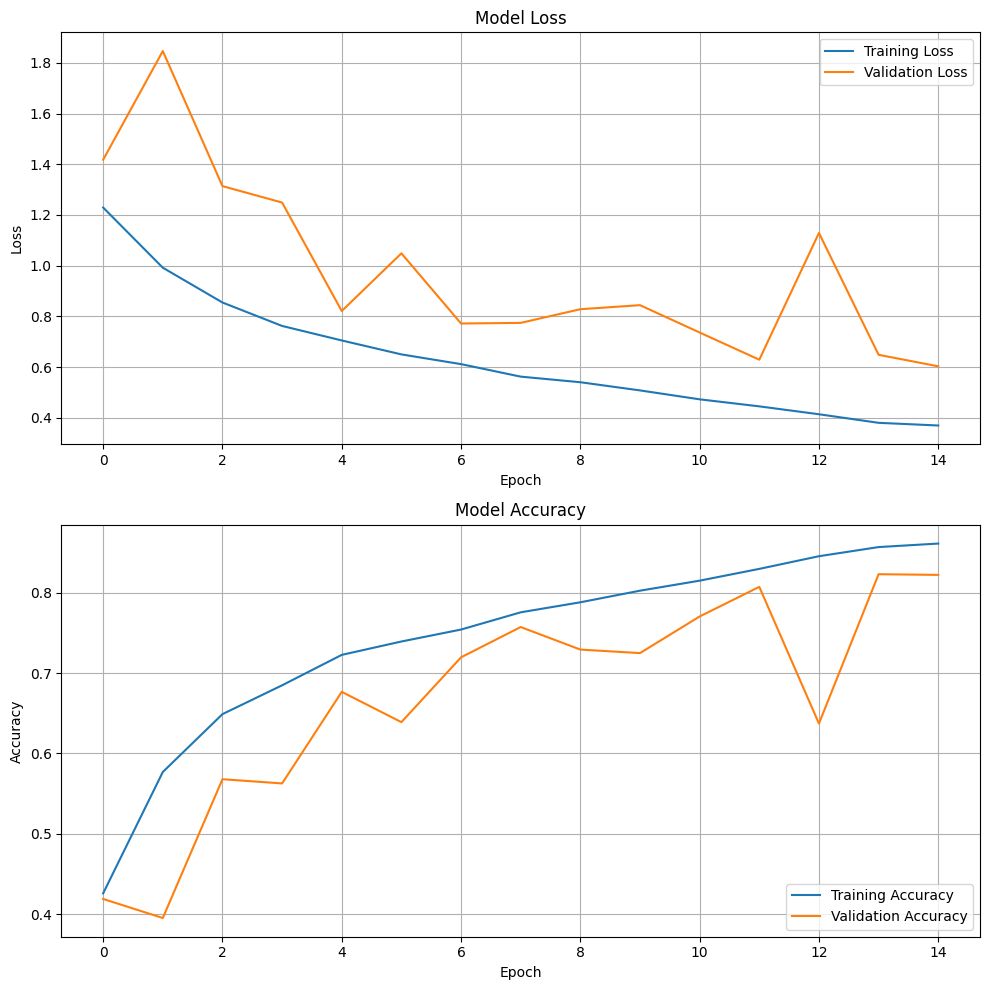

In [94]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training & validation loss values
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    # Plot training & validation accuracy values
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='lower right')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(best_model_history)

41/41 [==============================] - 4s 91ms/step


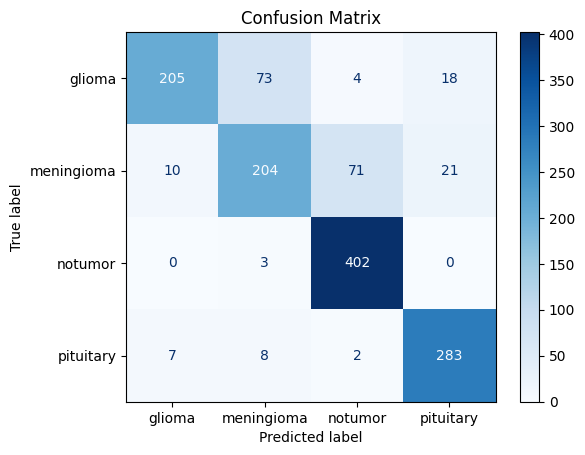

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set
test_generator.reset()  # Ensure the generator starts from the beginning
test_loss, test_accuracy = best_model.evaluate(test_generator)
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 83ms/step


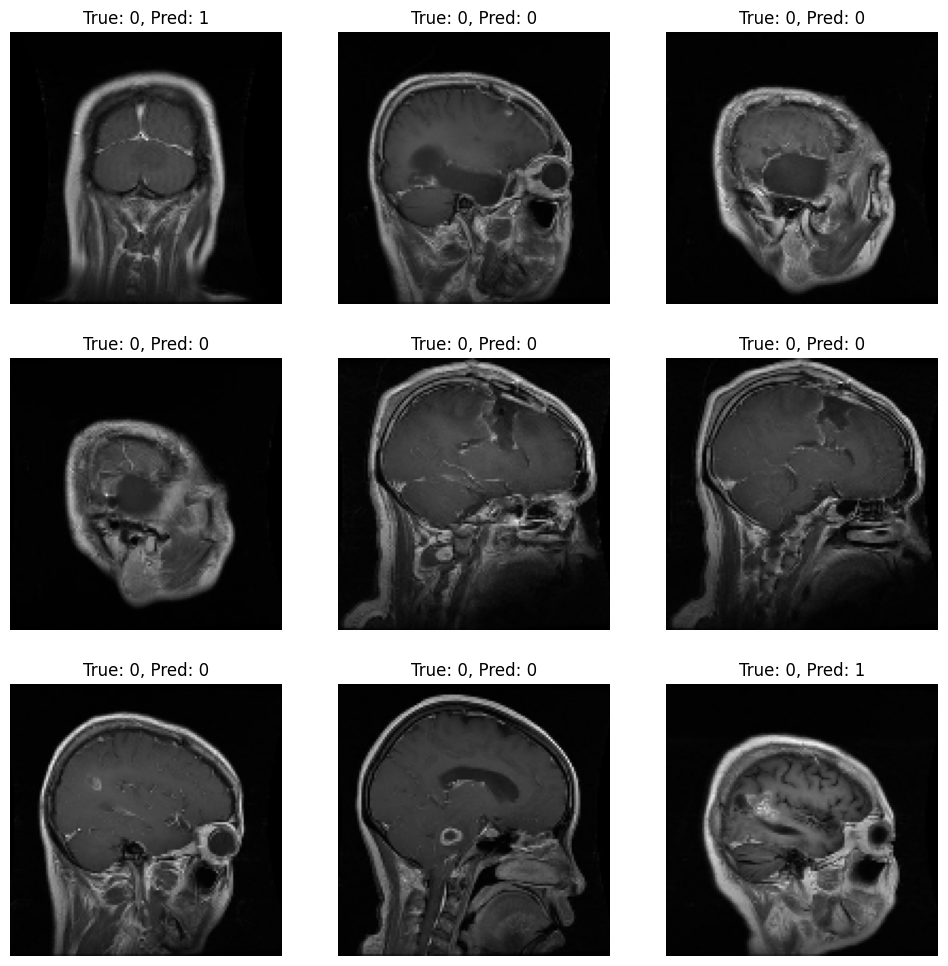

In [109]:
def plot_predictions(images, true_labels, predictions):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = np.argmax(true_labels[i])
        predicted_label = np.argmax(predictions[i])
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Get a batch of test images and labels
test_images, test_labels = next(test_generator)

# Predict the labels for the test images
predictions = best_model.predict(test_images)

# Plot the predictions
plot_predictions(test_images, test_labels, predictions)